In [1]:
import numpy as np
import pandas as pd
import shap
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Data preparation
class PhishingDataset(Dataset):
    def __init__(self, feature, label):
        self.X = feature
        self.y = label
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
        
 
# Define the NN model
class MLPClassifier(nn.Module):
    def __init__(self, n_features):
        super(MLPClassifier, self).__init__()
        self.flatten = nn.Flatten() #or not
        self.layers = nn.Sequential(
            nn.Linear(n_features, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(p=0.3),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        
    # def forward(self, x):
    #     return self.layers(x) 

    def forward(self, x):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float()
        return self.layers(x) 


shap.initjs()

# data pre-processing
df = pd.read_csv('/Users/qiaochufeng/Desktop/Cam/NNclassify/phishing_full.csv')
X = df.drop(columns=['id', 'CLASS_LABEL']).values
y = df['CLASS_LABEL'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Prepare PyTorch Datasets and Create DataLoader
train_dataset = PhishingDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
test_dataset = PhishingDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Initialize the model
model = MLPClassifier(n_features=48)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
n_epochs = 50
epochs = []
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Validation
    model.eval()
    with torch.no_grad():
        correct, total = 0, 0
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch)
            predicted = (torch.sigmoid(y_pred) > 0.5).float()
            total += y_batch.size(0)
            correct += (predicted == y_batch.unsqueeze(1)).sum().item()
        epochs.append(correct/total)
        print(f'Epoch {epoch+1}: {correct / total:.3f}')

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Epoch 1: 0.569
Epoch 2: 0.629
Epoch 3: 0.734
Epoch 4: 0.788
Epoch 5: 0.797
Epoch 6: 0.796
Epoch 7: 0.838
Epoch 8: 0.850
Epoch 9: 0.855
Epoch 10: 0.886
Epoch 11: 0.883
Epoch 12: 0.909
Epoch 13: 0.893
Epoch 14: 0.903
Epoch 15: 0.893
Epoch 16: 0.895
Epoch 17: 0.909
Epoch 18: 0.929
Epoch 19: 0.924
Epoch 20: 0.896
Epoch 21: 0.950
Epoch 22: 0.933
Epoch 23: 0.915
Epoch 24: 0.938
Epoch 25: 0.936
Epoch 26: 0.945
Epoch 27: 0.931
Epoch 28: 0.952
Epoch 29: 0.947
Epoch 30: 0.932
Epoch 31: 0.921
Epoch 32: 0.949
Epoch 33: 0.934
Epoch 34: 0.932
Epoch 35: 0.946
Epoch 36: 0.957
Epoch 37: 0.946
Epoch 38: 0.953
Epoch 39: 0.949
Epoch 40: 0.957
Epoch 41: 0.955
Epoch 42: 0.946
Epoch 43: 0.961
Epoch 44: 0.955
Epoch 45: 0.965
Epoch 46: 0.955
Epoch 47: 0.953
Epoch 48: 0.967
Epoch 49: 0.950
Epoch 50: 0.935


In [ ]:
explainer = shap.DeepExplainer(model, torch.from_numpy(X_train).float())
shap_values = explainer.shap_values(torch.from_numpy(X).float())

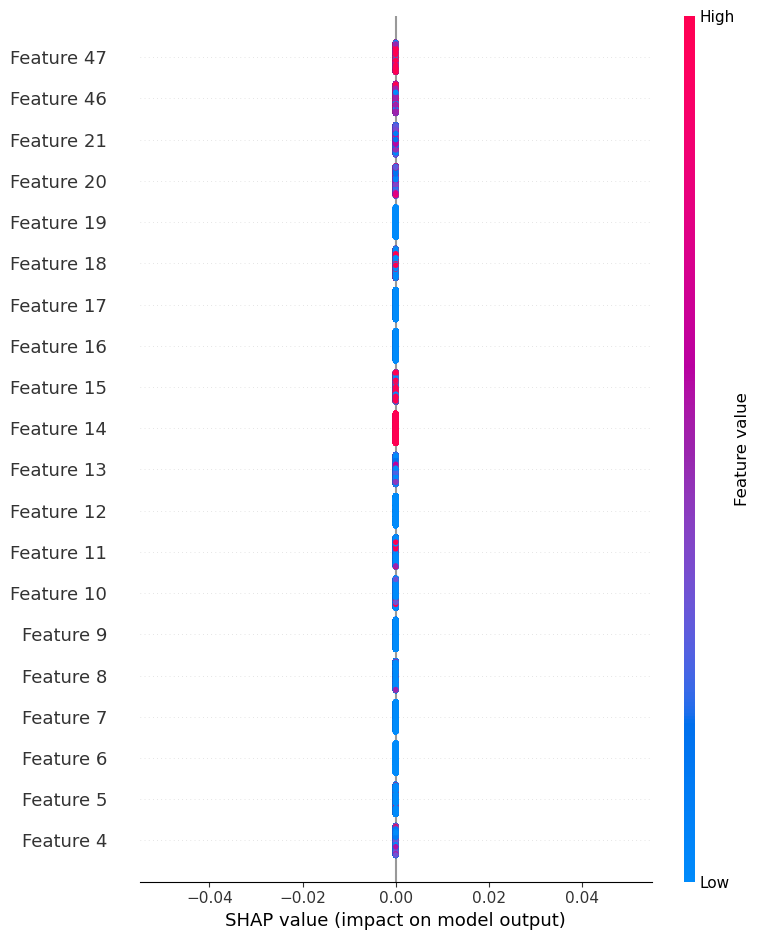

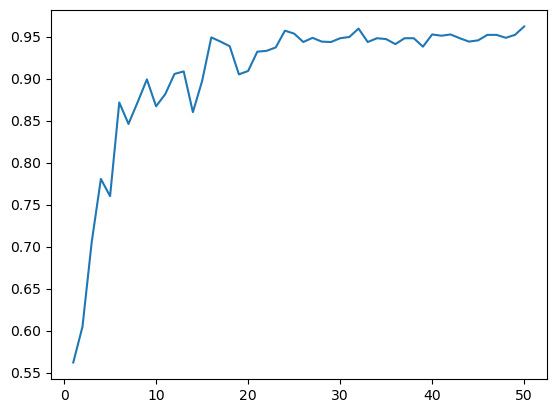

In [3]:
shap.summary_plot(shap_values, X)
plt.plot([i for i in range(1, 51)], epochs)
plt.show()

In [5]:
shap.initjs()
features = df.drop(['id', 'CLASS_LABEL'], axis=1)
features = features.columns.values
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test[0,:], feature_names=features)

In [3]:
explainer = shap.DeepExplainer(model, torch.from_numpy(X_train).float())
shap_values = explainer.shap_values(torch.from_numpy(X_test).float())

In [6]:
shap.plots.text(torch.from_numpy(shap_values[:,1]).float())

AttributeError: 'Tensor' object has no attribute 'base_values'

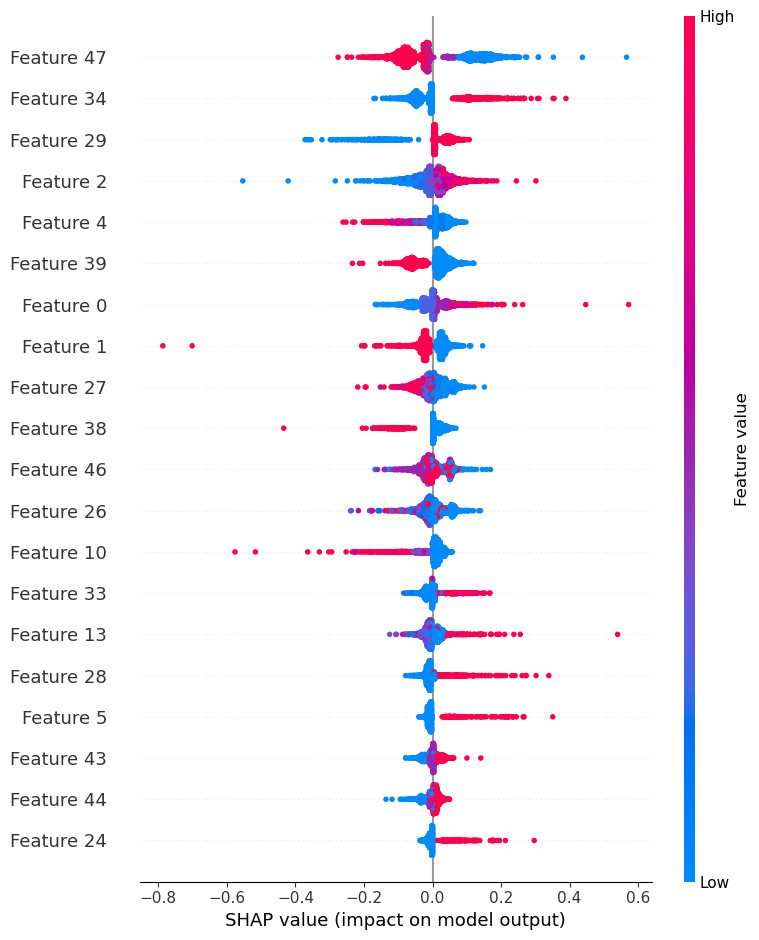

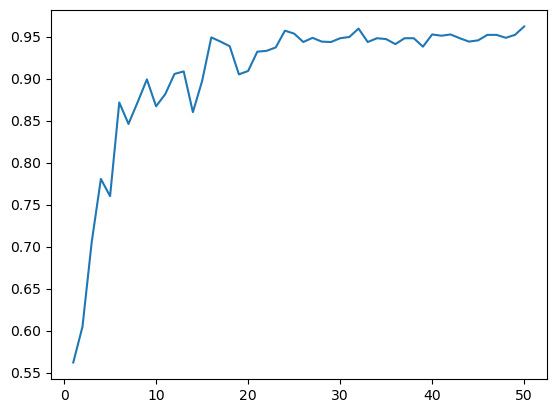

In [8]:
plt.figure(figsize=(20,30))
shap.summary_plot(shap_values, X_test)
plt.plot([i for i in range(1, 51)], epochs)
plt.show()

In [ ]:
import gradio as gr
def show_main():
    return  
demo = gr.Interface(fn=show_main, inputs=gr.Textbox(lines=2, placeholder="Enter url Here..."), 
                    outputs=[gr.Textbox(label='prediction'), gr.HTML(label = 'prediction1'), gr.HTML(label = 'prediction2')])
demo.launch(share=True)

In [55]:
shap.initjs()
features = df.drop(['id', 'CLASS_LABEL'], axis=1)
features = features.columns.values
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test[0,:], feature_names=features)

In [51]:
shap.force_plot(explainer.expected_value, shap_values[1], X_test[1], feature_names=features)

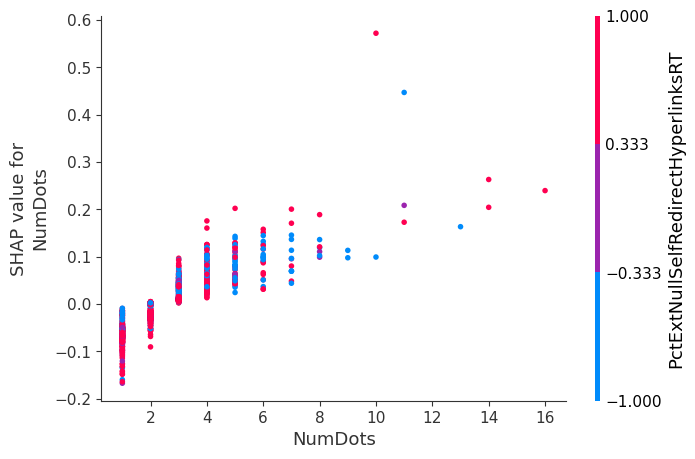

In [29]:
shap.dependence_plot(0, shap_values, X_test, feature_names=features)

In [38]:
import numpy as np

vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(features, vals)), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance

,col_name,feature_importance_vals
47,PctExtNullSelfRedirectHyperlinksRT,0.086388
34,FrequentDomainNameMismatch,0.055081
29,InsecureForms,0.047707
2,PathLevel,0.041805
4,NumDash,0.039373
39,IframeOrFrame,0.039372
0,NumDots,0.035864
1,SubdomainLevel,0.030492
27,PctExtResourceUrls,0.029454
38,SubmitInfoToEmail,0.029170


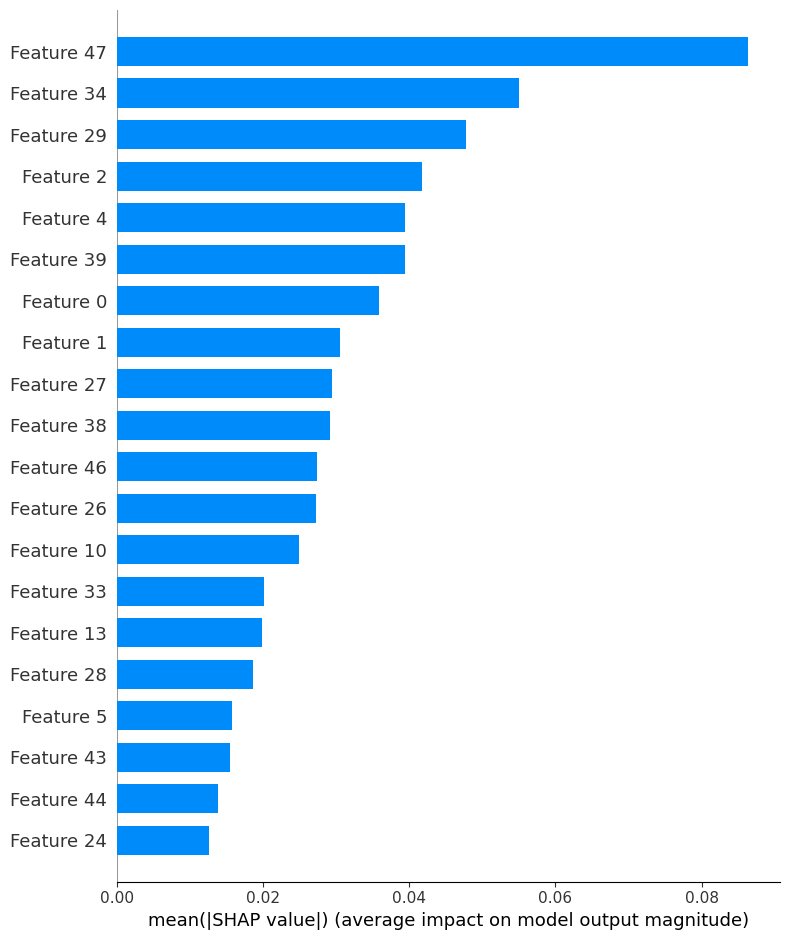

In [39]:
shap.summary_plot(shap_values, plot_type='bar')

In [69]:
# define a partition masker that uses our clustering
clustering = shap.utils.hclust(X_train, y_train)
masker = shap.maskers.Partition(X_train, clustering=clustering)

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
 88%|████████▊ | 42/48 [00:44<00:05,  1.01it/s]No/low signal found from feature 41 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
49it [00:52,  1.34s/it]                        


In [70]:
# explain the model again
def f(x):
    return model(x)

explainer2 = shap.Explainer(f, masker)
shap_values_partition = explainer2(X_test)

Permutation explainer: 2001it [00:23, 48.78it/s]                          


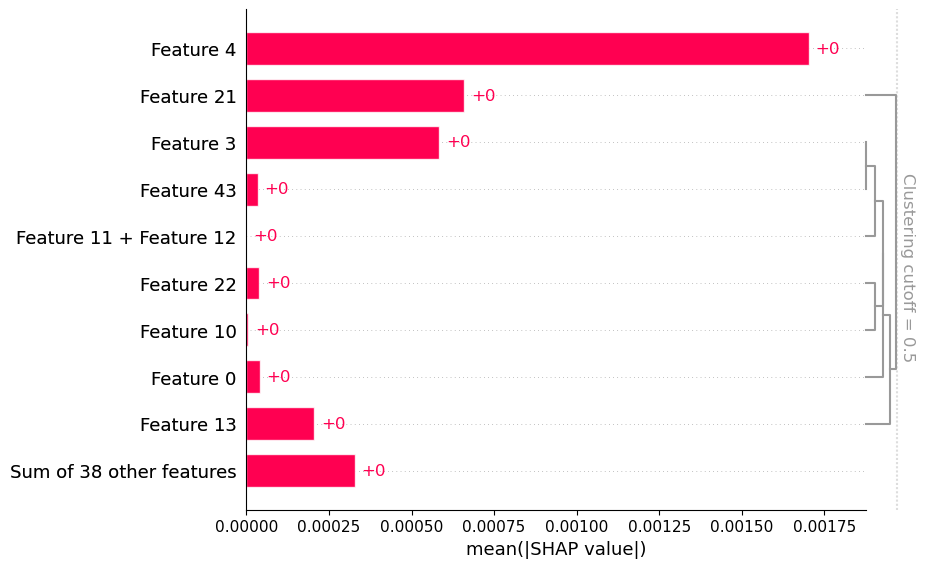

In [75]:
shap.plots.text(shap_values[:,:,1])